In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu111/torch1.10.0/index.html
!git clone https://github.com/open-mmlab/mmsegmentation.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.openmmlab.com/mmcv/dist/cu111/torch1.10.0/index.html
     |████████████████████████████████| 46.6 MB 12.2 MB/s 
     |████████████████████████████████| 190 kB 9.9 MB/s 
Cloning into 'mmsegmentation'...
remote: Enumerating objects: 7190, done.
remote: Counting objects: 100% (195/195), done.
remote: Compressing objects: 100% (157/157), done.
remote: Total 7190 (delta 51), reused 162 (delta 38), pack-reused 6995
Receiving objects: 100% (7190/7190), 13.43 MiB | 28.41 MiB/s, done.
Resolving deltas: 100% (5244/5244), done.


In [3]:
import torch

print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

Setup complete. Using torch 1.11.0+cu113 (Tesla P100-PCIE-16GB)


In [4]:
%cd mmsegmentation

/content/mmsegmentation


In [5]:
from mmseg.apis import inference_segmentor, init_segmentor, show_result_pyplot
import mmcv

In [6]:
import os.path as osp
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [7]:
!mkdir checkpoints
!wget -O //content/mmsegmentation/checkpoints/segformer_mit-b5_8x1_1024x1024_160k_cityscapes_20211206_072934-87a052ec.pth https://download.openmmlab.com/mmsegmentation/v0.5/segformer/segformer_mit-b5_8x1_1024x1024_160k_cityscapes/segformer_mit-b5_8x1_1024x1024_160k_cityscapes_20211206_072934-87a052ec.pth

--2022-05-30 01:51:26--  https://download.openmmlab.com/mmsegmentation/v0.5/segformer/segformer_mit-b5_8x1_1024x1024_160k_cityscapes/segformer_mit-b5_8x1_1024x1024_160k_cityscapes_20211206_072934-87a052ec.pth
Resolving download.openmmlab.com (download.openmmlab.com)... 47.88.36.72
Connecting to download.openmmlab.com (download.openmmlab.com)|47.88.36.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 328290585 (313M) [application/octet-stream]
Saving to: ‘//content/mmsegmentation/checkpoints/segformer_mit-b5_8x1_1024x1024_160k_cityscapes_20211206_072934-87a052ec.pth’

//content/mmsegment 100%[===================>] 313.08M  13.3MB/s    in 24s     

2022-05-30 01:51:51 (13.0 MB/s) - ‘//content/mmsegmentation/checkpoints/segformer_mit-b5_8x1_1024x1024_160k_cityscapes_20211206_072934-87a052ec.pth’ saved [328290585/328290585]



In [8]:
from mmseg.datasets.builder import DATASETS
from mmseg.datasets.custom import CustomDataset

classes = ('background', 'building','Boundary')
palette = [[0, 0, 0], [0, 0, 255], [0, 0, 0]]

@DATASETS.register_module()
class SIADataset(CustomDataset):
  CLASSES = classes
  PALETTE = palette
  def __init__(self, split, **kwargs):
    super().__init__(img_suffix='.png', seg_map_suffix='.png', 
                     split=split, **kwargs)
    assert osp.exists(self.img_dir) and self.split is not None

In [9]:
# config 파일을 설정하고, 다운로드 받은 pretrained 모델을 checkpoint로 설정. 
config_file = '/content/mmsegmentation/configs/segformer/segformer_mit-b5_8x1_1024x1024_160k_cityscapes.py'
checkpoint_file = '/content/mmsegmentation/checkpoints/segformer_mit-b5_8x1_1024x1024_160k_cityscapes_20211206_072934-87a052ec.pth'

from mmcv import Config

cfg = Config.fromfile(config_file)
print(cfg.pretty_text)

norm_cfg = dict(type='SyncBN', requires_grad=True)
model = dict(
    type='EncoderDecoder',
    pretrained=None,
    backbone=dict(
        type='MixVisionTransformer',
        in_channels=3,
        embed_dims=64,
        num_stages=4,
        num_layers=[3, 6, 40, 3],
        num_heads=[1, 2, 5, 8],
        patch_sizes=[7, 3, 3, 3],
        sr_ratios=[8, 4, 2, 1],
        out_indices=(0, 1, 2, 3),
        mlp_ratio=4,
        qkv_bias=True,
        drop_rate=0.0,
        attn_drop_rate=0.0,
        drop_path_rate=0.1,
        init_cfg=dict(type='Pretrained', checkpoint='pretrain/mit_b5.pth')),
    decode_head=dict(
        type='SegformerHead',
        in_channels=[64, 128, 320, 512],
        in_index=[0, 1, 2, 3],
        channels=256,
        dropout_ratio=0.1,
        num_classes=19,
        norm_cfg=dict(type='SyncBN', requires_grad=True),
        align_corners=False,
        loss_decode=dict(
            type='CrossEntropyLoss', use_sigmoid=False, loss_weight=1.0)),
    train_cf

In [10]:
cfg.norm_cfg = dict(type='BN', requires_grad=True)
#cfg.model.backbone.norm_cfg = cfg.norm_cfg
cfg.model.decode_head.norm_cfg = cfg.norm_cfg

cfg.device='cuda'

cfg.model.decode_head.num_classes = 3

#cfg.data.samples_per_gpu=2
#cfg.data.workers_per_gpu=2

cfg.model.decode_head.loss_decode = [dict(type='DiceLoss', loss_weight = 1.0),
                                     dict(type='FocalLoss', loss_weight = 1.0),
                                     dict(type='LovaszLoss', loss_weight = 1.0, reduction='none')]


In [11]:
cfg.img_norm_cfg = dict(
    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)
cfg.crop_size = (512, 512)
cfg.train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    dict(type='Resize', img_scale=(1024, 1024), ratio_range=(0.5, 2.0)),
    dict(type='RandomCrop', crop_size=cfg.crop_size, cat_max_ratio=0.75),
    dict(type='RandomFlip', flip_ratio=0.5),
    dict(type='RandomCutOut',prob=0.5,n_holes=(1,1000),cutout_ratio=[(0,1)]),
    dict(type='PhotoMetricDistortion'),
    dict(type='Normalize', **cfg.img_norm_cfg),
    dict(type='Pad', size=cfg.crop_size, pad_val=0, seg_pad_val=255),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_semantic_seg']),
]

cfg.val_pipeline = [
                    dict(type='LoadImageFromFile'),
                    dict(
                        type='MultiScaleFlipAug',
                        img_scale=(1024, 1024),
                        flip=False,
                        transforms=[
                                    dict(type='Resize', keep_ratio=True),
                                    dict(type='RandomFlip'),
                                    dict(
                                        type='Normalize',
                                        mean=[123.675, 116.28, 103.53],
                                        std=[58.395, 57.12, 57.375],
                                        to_rgb=True),
                                    dict(type='ImageToTensor', keys=['img']),
                                    dict(type='Collect', keys=['img'])
                                    ]),
                    
]

cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale=(1024, 1024),
        img_ratios=[0.5, 0.75, 1.0, 1.25, 1.5, 1.75],
        flip=False,
        transforms=[
            dict(type='Resize', keep_ratio=True),
            #dict(type='ResizeToMultiple', size_divisor=32),
            dict(type='RandomFlip'),
            dict(type='Normalize', **cfg.img_norm_cfg),
            dict(type='ImageToTensor', keys=['img']),
            dict(type='Collect', keys=['img']),
        ])
]

In [12]:
cfg.dataset_type = 'SIADataset'
cfg.data_root = '/content/drive/MyDrive/SIA'

cfg.data.train.type = 'SIADataset'
cfg.data.train.data_root = '/content/drive/MyDrive/SIA'
cfg.data.train.img_dir = 'Data_set/building_dataset/img_dir/train'
cfg.data.train.ann_dir = 'Data_set/building_dataset/contour_ann_dir/train'
cfg.data.train.pipeline = cfg.train_pipeline
cfg.data.train.split = '/content/drive/MyDrive/SIA/Data_set/building_dataset/mask_dir/train/up_train_building.txt'

cfg.data.val.type = 'SIADataset'
cfg.data.val.data_root = '/content/drive/MyDrive/SIA'
cfg.data.val.img_dir = 'Data_set/building_dataset/img_dir/train'
cfg.data.val.ann_dir = 'Data_set/building_dataset/contour_ann_dir/train'
cfg.data.val.pipeline = cfg.test_pipeline
cfg.data.val.split = '/content/drive/MyDrive/SIA/Data_set/building_dataset/mask_dir/train/up_val_building.txt'

cfg.data.test.type = 'SIADataset'
cfg.data.test.data_root = '/content/drive/MyDrive/SIA'
cfg.data.test.img_dir = 'Data_set/building_dataset/img_dir/val'
cfg.data.test.ann_dir = 'Data_set/building_dataset/contour_ann_dir/val'
cfg.data.test.pipeline = cfg.test_pipeline
cfg.data.test.split = '/content/drive/MyDrive/SIA/Data_set/building_dataset/mask_dir/val/up.txt'

<pre><code>cfg.data.train.type = 'SIADataset'
cfg.data.train.data_root = '/content/drive/MyDrive/SIA'
cfg.data.train.img_dir = 'Data_set/building_dataset/img_dir'
cfg.data.train.ann_dir = 'Data_set/building_dataset/ann_dir'
cfg.data.train.pipeline = cfg.train_pipeline
cfg.data.train.split = '/content/drive/MyDrive/SIA/Data_set/building_dataset/mask_dir/train/up_train_building.txt'
</code></pre>

In [13]:
cfg.load_from = '/content/mmsegmentation/checkpoints/segformer_mit-b5_8x1_1024x1024_160k_cityscapes_20211206_072934-87a052ec.pth'

# Set up working dir to save files and logs.
cfg.work_dir = '/content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/LV2_building/batch1_dice_focal_lovasz_cutout_1000_0_1'

In [14]:
cfg.runner.max_iteTrs = 200
cfg.log_config.interval = 100
cfg.evaluation.interval = 1000  # 모델 학습시 평가를 몇 번째 iteration마다 할 것인지 지정
cfg.checkpoint_config.interval = 1000  # 모델 학습시 학습한 모델을 몇 번째 iteration마다 저장할 것인지 지정

cfg.runner = dict(type='IterBasedRunner', max_iters=20000)  # Iteration으로 동작, Epoch로 동작하게 변경할 수도 있음
# cfg.runner = dict(type='EpochBasedRunner', max_epochs=4000)  # Epoch로 변경
cfg.workflow = [('train', 1)]

# Set seed to facitate reproducing the result
cfg.seed = 0
#set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

# Let's have a look at the final config used for training
print(f'Config:\n{cfg.pretty_text}')

Config:
norm_cfg = dict(type='BN', requires_grad=True)
model = dict(
    type='EncoderDecoder',
    pretrained=None,
    backbone=dict(
        type='MixVisionTransformer',
        in_channels=3,
        embed_dims=64,
        num_stages=4,
        num_layers=[3, 6, 40, 3],
        num_heads=[1, 2, 5, 8],
        patch_sizes=[7, 3, 3, 3],
        sr_ratios=[8, 4, 2, 1],
        out_indices=(0, 1, 2, 3),
        mlp_ratio=4,
        qkv_bias=True,
        drop_rate=0.0,
        attn_drop_rate=0.0,
        drop_path_rate=0.1,
        init_cfg=dict(type='Pretrained', checkpoint='pretrain/mit_b5.pth')),
    decode_head=dict(
        type='SegformerHead',
        in_channels=[64, 128, 320, 512],
        in_index=[0, 1, 2, 3],
        channels=256,
        dropout_ratio=0.1,
        num_classes=3,
        norm_cfg=dict(type='BN', requires_grad=True),
        align_corners=False,
        loss_decode=[
            dict(type='DiceLoss', loss_weight=1.0),
            dict(type='FocalLoss', loss_

### 모델 학습

In [15]:
from mmseg.datasets import build_dataset
from mmseg.models import build_segmentor
from mmseg.apis import train_segmentor

# Build the dataset
datasets = [build_dataset(cfg.data.train)]

# Build the detector
model = build_segmentor(
    cfg.model, train_cfg=cfg.get('train_cfg'), test_cfg=cfg.get('test_cfg'))

# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_segmentor(model, datasets, cfg, distributed=False, validate=True,
                meta=dict(CLASSES=classes, PALETTE=palette))

2022-05-30 01:51:54,725 - mmseg - INFO - Loaded 537 images
2022-05-30 01:52:08,501 - mmseg - INFO - Loaded 113 images
2022-05-30 01:52:08,504 - mmseg - INFO - load checkpoint from local path: /content/mmsegmentation/checkpoints/segformer_mit-b5_8x1_1024x1024_160k_cityscapes_20211206_072934-87a052ec.pth
2022-05-30 01:52:09,010 - mmseg - WARNING - The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([19, 256, 1, 1]) from checkpoint, the shape in current model is torch.Size([3, 256, 1, 1]).
size mismatch for decode_head.conv_seg.bias: copying a param with shape torch.Size([19]) from checkpoint, the shape in current model is torch.Size([3]).
2022-05-30 01:52:09,016 - mmseg - INFO - Start running, host: root@ca4cdd2a8213, work_dir: /content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/LV2_building/batch1_dice_focal_lovasz_cutout_1000_1_1
2022-05-30 01:52:09,017 - mmseg - INFO - Hooks will be executed in

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.2 task/s, elapsed: 469s, ETA:     0s

2022-05-30 02:09:01,724 - mmseg - INFO - per class results:
2022-05-30 02:09:01,726 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 85.77 | 90.39 |
|  building  | 71.71 | 85.08 |
|  Boundary  | 44.43 | 65.27 |
+------------+-------+-------+
2022-05-30 02:09:01,728 - mmseg - INFO - Summary:
2022-05-30 02:09:01,731 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 85.59 | 67.3 | 80.25 |
+-------+------+-------+
2022-05-30 02:09:01,733 - mmseg - INFO - Iter(val) [113]	aAcc: 0.8559, mIoU: 0.6730, mAcc: 0.8025, IoU.background: 0.8577, IoU.building: 0.7171, IoU.Boundary: 0.4443, Acc.background: 0.9039, Acc.building: 0.8508, Acc.Boundary: 0.6527
2022-05-30 02:09:35,635 - mmseg - INFO - Iter [1100/20000]	lr: 4.154e-05, eta: 4:59:41, time: 5.025, data_time: 4.712, memory: 3323, decode.loss_dice: 0.2075, decode.loss_focal: 0.0460, decode.loss_lovasz: 0.3845, decode.acc_seg: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 430s, ETA:     0s

2022-05-30 02:21:40,249 - mmseg - INFO - per class results:
2022-05-30 02:21:40,251 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 88.63 | 92.64 |
|  building  | 74.62 | 85.31 |
|  Boundary  | 49.78 | 70.84 |
+------------+-------+-------+
2022-05-30 02:21:40,254 - mmseg - INFO - Summary:
2022-05-30 02:21:40,255 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 87.81 | 71.01 | 82.93 |
+-------+-------+-------+
2022-05-30 02:21:40,257 - mmseg - INFO - Iter(val) [113]	aAcc: 0.8781, mIoU: 0.7101, mAcc: 0.8293, IoU.background: 0.8863, IoU.building: 0.7462, IoU.Boundary: 0.4978, Acc.background: 0.9264, Acc.building: 0.8531, Acc.Boundary: 0.7084
2022-05-30 02:22:12,072 - mmseg - INFO - Iter [2100/20000]	lr: 5.370e-05, eta: 4:16:08, time: 4.615, data_time: 4.302, memory: 3323, decode.loss_dice: 0.1784, decode.loss_focal: 0.0453, decode.loss_lovasz: 0.3462, decode.acc_

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 431s, ETA:     0s

2022-05-30 02:34:19,278 - mmseg - INFO - per class results:
2022-05-30 02:34:19,280 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 88.61 | 93.44 |
|  building  | 75.89 | 86.26 |
|  Boundary  | 50.02 | 68.38 |
+------------+-------+-------+
2022-05-30 02:34:19,281 - mmseg - INFO - Summary:
2022-05-30 02:34:19,284 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 88.19 | 71.51 | 82.69 |
+-------+-------+-------+
2022-05-30 02:34:19,286 - mmseg - INFO - Iter(val) [113]	aAcc: 0.8819, mIoU: 0.7151, mAcc: 0.8269, IoU.background: 0.8861, IoU.building: 0.7589, IoU.Boundary: 0.5002, Acc.background: 0.9344, Acc.building: 0.8626, Acc.Boundary: 0.6838
2022-05-30 02:34:51,099 - mmseg - INFO - Iter [3100/20000]	lr: 5.070e-05, eta: 3:52:47, time: 4.629, data_time: 4.317, memory: 3323, decode.loss_dice: 0.1690, decode.loss_focal: 0.0433, decode.loss_lovasz: 0.3313, decode.acc_

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 431s, ETA:     0s

2022-05-30 02:46:59,718 - mmseg - INFO - per class results:
2022-05-30 02:46:59,720 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 88.17 | 91.91 |
|  building  | 76.68 | 86.95 |
|  Boundary  | 50.43 | 72.55 |
+------------+-------+-------+
2022-05-30 02:46:59,721 - mmseg - INFO - Summary:
2022-05-30 02:46:59,724 - mmseg - INFO - 
+------+-------+------+
| aAcc |  mIoU | mAcc |
+------+-------+------+
| 88.0 | 71.76 | 83.8 |
+------+-------+------+
2022-05-30 02:46:59,726 - mmseg - INFO - Iter(val) [113]	aAcc: 0.8800, mIoU: 0.7176, mAcc: 0.8380, IoU.background: 0.8817, IoU.building: 0.7668, IoU.Boundary: 0.5043, Acc.background: 0.9191, Acc.building: 0.8695, Acc.Boundary: 0.7255
2022-05-30 02:47:31,691 - mmseg - INFO - Iter [4100/20000]	lr: 4.770e-05, eta: 3:34:45, time: 4.631, data_time: 4.317, memory: 3323, decode.loss_dice: 0.1685, decode.loss_focal: 0.0434, decode.loss_lovasz: 0.3317, decode.acc_seg: 85.74

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 432s, ETA:     0s

2022-05-30 02:59:40,413 - mmseg - INFO - per class results:
2022-05-30 02:59:40,414 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 88.91 | 92.32 |
|  building  | 76.81 | 89.17 |
|  Boundary  | 51.01 | 70.23 |
+------------+-------+-------+
2022-05-30 02:59:40,416 - mmseg - INFO - Summary:
2022-05-30 02:59:40,419 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 88.46 | 72.24 | 83.9 |
+-------+-------+------+
2022-05-30 02:59:40,421 - mmseg - INFO - Iter(val) [113]	aAcc: 0.8846, mIoU: 0.7224, mAcc: 0.8390, IoU.background: 0.8891, IoU.building: 0.7681, IoU.Boundary: 0.5101, Acc.background: 0.9232, Acc.building: 0.8917, Acc.Boundary: 0.7023
2022-05-30 03:00:12,289 - mmseg - INFO - Iter [5100/20000]	lr: 4.470e-05, eta: 3:18:49, time: 4.635, data_time: 4.322, memory: 3323, decode.loss_dice: 0.1515, decode.loss_focal: 0.0359, decode.loss_lovasz: 0.3032, decode.acc_seg: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 432s, ETA:     0s

2022-05-30 03:12:22,035 - mmseg - INFO - per class results:
2022-05-30 03:12:22,036 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background |  90.1 | 95.07 |
|  building  | 77.38 | 86.51 |
|  Boundary  | 51.38 | 68.01 |
+------------+-------+-------+
2022-05-30 03:12:22,040 - mmseg - INFO - Summary:
2022-05-30 03:12:22,042 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 89.21 | 72.96 | 83.2 |
+-------+-------+------+
2022-05-30 03:12:22,043 - mmseg - INFO - Iter(val) [113]	aAcc: 0.8921, mIoU: 0.7296, mAcc: 0.8320, IoU.background: 0.9010, IoU.building: 0.7738, IoU.Boundary: 0.5138, Acc.background: 0.9507, Acc.building: 0.8651, Acc.Boundary: 0.6801
2022-05-30 03:12:53,888 - mmseg - INFO - Iter [6100/20000]	lr: 4.170e-05, eta: 3:03:59, time: 4.634, data_time: 4.321, memory: 3323, decode.loss_dice: 0.1489, decode.loss_focal: 0.0386, decode.loss_lovasz: 0.2967, decode.acc_seg: 

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 432s, ETA:     0s

2022-05-30 03:25:01,609 - mmseg - INFO - per class results:
2022-05-30 03:25:01,611 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 89.76 | 93.67 |
|  building  | 77.75 | 88.51 |
|  Boundary  | 52.51 | 70.46 |
+------------+-------+-------+
2022-05-30 03:25:01,612 - mmseg - INFO - Summary:
2022-05-30 03:25:01,616 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 89.17 | 73.34 | 84.21 |
+-------+-------+-------+
2022-05-30 03:25:01,619 - mmseg - INFO - Iter(val) [113]	aAcc: 0.8917, mIoU: 0.7334, mAcc: 0.8421, IoU.background: 0.8976, IoU.building: 0.7775, IoU.Boundary: 0.5251, Acc.background: 0.9367, Acc.building: 0.8851, Acc.Boundary: 0.7046
2022-05-30 03:25:33,477 - mmseg - INFO - Iter [7100/20000]	lr: 3.870e-05, eta: 2:49:42, time: 4.636, data_time: 4.323, memory: 3323, decode.loss_dice: 0.1462, decode.loss_focal: 0.0367, decode.loss_lovasz: 0.2986, decode.acc_

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 431s, ETA:     0s

2022-05-30 03:37:39,129 - mmseg - INFO - per class results:
2022-05-30 03:37:39,131 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 89.84 | 93.63 |
|  building  | 78.13 | 88.71 |
|  Boundary  | 52.73 |  71.0 |
+------------+-------+-------+
2022-05-30 03:37:39,134 - mmseg - INFO - Summary:
2022-05-30 03:37:39,136 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 89.27 | 73.57 | 84.45 |
+-------+-------+-------+
2022-05-30 03:37:39,139 - mmseg - INFO - Iter(val) [113]	aAcc: 0.8927, mIoU: 0.7357, mAcc: 0.8445, IoU.background: 0.8984, IoU.building: 0.7813, IoU.Boundary: 0.5273, Acc.background: 0.9363, Acc.building: 0.8871, Acc.Boundary: 0.7100
2022-05-30 03:38:13,175 - mmseg - INFO - Iter [8100/20000]	lr: 3.570e-05, eta: 2:35:49, time: 4.653, data_time: 4.339, memory: 3323, decode.loss_dice: 0.1384, decode.loss_focal: 0.0334, decode.loss_lovasz: 0.2895, decode.acc_

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 432s, ETA:     0s

2022-05-30 03:50:20,111 - mmseg - INFO - per class results:
2022-05-30 03:50:20,113 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 90.23 | 94.75 |
|  building  | 78.12 | 86.86 |
|  Boundary  | 53.21 | 71.02 |
+------------+-------+-------+
2022-05-30 03:50:20,115 - mmseg - INFO - Summary:
2022-05-30 03:50:20,117 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 89.51 | 73.85 | 84.21 |
+-------+-------+-------+
2022-05-30 03:50:20,118 - mmseg - INFO - Iter(val) [113]	aAcc: 0.8951, mIoU: 0.7385, mAcc: 0.8421, IoU.background: 0.9023, IoU.building: 0.7812, IoU.Boundary: 0.5321, Acc.background: 0.9475, Acc.building: 0.8686, Acc.Boundary: 0.7102
2022-05-30 03:50:51,925 - mmseg - INFO - Iter [9100/20000]	lr: 3.270e-05, eta: 2:22:11, time: 4.638, data_time: 4.326, memory: 3323, decode.loss_dice: 0.1409, decode.loss_focal: 0.0344, decode.loss_lovasz: 0.2896, decode.acc_

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 432s, ETA:     0s

2022-05-30 04:03:01,958 - mmseg - INFO - per class results:
2022-05-30 04:03:01,961 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 89.66 | 93.21 |
|  building  | 77.76 | 89.64 |
|  Boundary  | 52.46 | 70.19 |
+------------+-------+-------+
2022-05-30 04:03:01,963 - mmseg - INFO - Summary:
2022-05-30 04:03:01,964 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 89.12 | 73.29 | 84.34 |
+-------+-------+-------+
2022-05-30 04:03:01,968 - mmseg - INFO - Iter(val) [113]	aAcc: 0.8912, mIoU: 0.7329, mAcc: 0.8434, IoU.background: 0.8966, IoU.building: 0.7776, IoU.Boundary: 0.5246, Acc.background: 0.9321, Acc.building: 0.8964, Acc.Boundary: 0.7019
2022-05-30 04:03:33,565 - mmseg - INFO - Iter [10100/20000]	lr: 2.970e-05, eta: 2:08:48, time: 4.637, data_time: 4.326, memory: 3323, decode.loss_dice: 0.1435, decode.loss_focal: 0.0341, decode.loss_lovasz: 0.2967, decode.acc

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 432s, ETA:     0s

2022-05-30 04:15:40,480 - mmseg - INFO - per class results:
2022-05-30 04:15:40,481 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 90.12 |  95.5 |
|  building  | 77.62 | 85.96 |
|  Boundary  | 52.88 |  68.9 |
+------------+-------+-------+
2022-05-30 04:15:40,485 - mmseg - INFO - Summary:
2022-05-30 04:15:40,488 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 89.46 | 73.54 | 83.45 |
+-------+-------+-------+
2022-05-30 04:15:40,492 - mmseg - INFO - Iter(val) [113]	aAcc: 0.8946, mIoU: 0.7354, mAcc: 0.8345, IoU.background: 0.9012, IoU.building: 0.7762, IoU.Boundary: 0.5288, Acc.background: 0.9550, Acc.building: 0.8596, Acc.Boundary: 0.6890
2022-05-30 04:16:12,276 - mmseg - INFO - Iter [11100/20000]	lr: 2.670e-05, eta: 1:55:30, time: 4.639, data_time: 4.327, memory: 3323, decode.loss_dice: 0.1358, decode.loss_focal: 0.0323, decode.loss_lovasz: 0.2817, decode.acc

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 432s, ETA:     0s

2022-05-30 04:28:19,446 - mmseg - INFO - per class results:
2022-05-30 04:28:19,448 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 90.29 | 93.82 |
|  building  | 78.74 | 88.01 |
|  Boundary  | 53.68 | 73.49 |
+------------+-------+-------+
2022-05-30 04:28:19,450 - mmseg - INFO - Summary:
2022-05-30 04:28:19,451 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 89.56 | 74.24 | 85.11 |
+-------+-------+-------+
2022-05-30 04:28:19,455 - mmseg - INFO - Iter(val) [113]	aAcc: 0.8956, mIoU: 0.7424, mAcc: 0.8511, IoU.background: 0.9029, IoU.building: 0.7874, IoU.Boundary: 0.5368, Acc.background: 0.9382, Acc.building: 0.8801, Acc.Boundary: 0.7349
2022-05-30 04:28:51,153 - mmseg - INFO - Iter [12100/20000]	lr: 2.370e-05, eta: 1:42:18, time: 4.640, data_time: 4.329, memory: 3323, decode.loss_dice: 0.1304, decode.loss_focal: 0.0317, decode.loss_lovasz: 0.2755, decode.acc

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 432s, ETA:     0s

2022-05-30 04:40:58,033 - mmseg - INFO - per class results:
2022-05-30 04:40:58,035 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 90.57 | 95.24 |
|  building  | 78.45 | 86.58 |
|  Boundary  | 53.56 | 71.01 |
+------------+-------+-------+
2022-05-30 04:40:58,038 - mmseg - INFO - Summary:
2022-05-30 04:40:58,040 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 89.75 | 74.19 | 84.27 |
+-------+-------+-------+
2022-05-30 04:40:58,044 - mmseg - INFO - Iter(val) [113]	aAcc: 0.8975, mIoU: 0.7419, mAcc: 0.8427, IoU.background: 0.9057, IoU.building: 0.7845, IoU.Boundary: 0.5356, Acc.background: 0.9524, Acc.building: 0.8658, Acc.Boundary: 0.7101
2022-05-30 04:41:29,742 - mmseg - INFO - Iter [13100/20000]	lr: 2.070e-05, eta: 1:29:11, time: 4.636, data_time: 4.324, memory: 3323, decode.loss_dice: 0.1278, decode.loss_focal: 0.0305, decode.loss_lovasz: 0.2682, decode.acc

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 432s, ETA:     0s

2022-05-30 04:53:38,343 - mmseg - INFO - per class results:
2022-05-30 04:53:38,345 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background |  90.6 | 94.39 |
|  building  |  79.1 | 88.97 |
|  Boundary  | 53.81 |  71.3 |
+------------+-------+-------+
2022-05-30 04:53:38,347 - mmseg - INFO - Summary:
2022-05-30 04:53:38,350 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 89.84 | 74.51 | 84.89 |
+-------+-------+-------+
2022-05-30 04:53:38,353 - mmseg - INFO - Iter(val) [113]	aAcc: 0.8984, mIoU: 0.7451, mAcc: 0.8489, IoU.background: 0.9060, IoU.building: 0.7910, IoU.Boundary: 0.5381, Acc.background: 0.9439, Acc.building: 0.8897, Acc.Boundary: 0.7130
2022-05-30 04:54:10,075 - mmseg - INFO - Iter [14100/20000]	lr: 1.770e-05, eta: 1:16:09, time: 4.635, data_time: 4.323, memory: 3323, decode.loss_dice: 0.1256, decode.loss_focal: 0.0299, decode.loss_lovasz: 0.2638, decode.acc

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 432s, ETA:     0s

2022-05-30 05:06:15,190 - mmseg - INFO - per class results:
2022-05-30 05:06:15,193 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 90.71 |  94.5 |
|  building  | 78.78 | 87.09 |
|  Boundary  | 54.29 | 73.88 |
+------------+-------+-------+
2022-05-30 05:06:15,195 - mmseg - INFO - Summary:
2022-05-30 05:06:15,197 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 89.81 | 74.6 | 85.16 |
+-------+------+-------+
2022-05-30 05:06:15,199 - mmseg - INFO - Iter(val) [113]	aAcc: 0.8981, mIoU: 0.7460, mAcc: 0.8516, IoU.background: 0.9071, IoU.building: 0.7878, IoU.Boundary: 0.5429, Acc.background: 0.9450, Acc.building: 0.8709, Acc.Boundary: 0.7388
2022-05-30 05:06:49,088 - mmseg - INFO - Iter [15100/20000]	lr: 1.470e-05, eta: 1:03:10, time: 4.658, data_time: 4.345, memory: 3323, decode.loss_dice: 0.1268, decode.loss_focal: 0.0313, decode.loss_lovasz: 0.2703, decode.acc_seg:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 432s, ETA:     0s

2022-05-30 05:18:55,989 - mmseg - INFO - per class results:
2022-05-30 05:18:55,991 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 90.77 | 94.68 |
|  building  |  79.4 | 88.98 |
|  Boundary  | 53.98 | 71.05 |
+------------+-------+-------+
2022-05-30 05:18:55,992 - mmseg - INFO - Summary:
2022-05-30 05:18:55,995 - mmseg - INFO - 
+-------+-------+------+
|  aAcc |  mIoU | mAcc |
+-------+-------+------+
| 89.99 | 74.72 | 84.9 |
+-------+-------+------+
2022-05-30 05:18:55,997 - mmseg - INFO - Iter(val) [113]	aAcc: 0.8999, mIoU: 0.7472, mAcc: 0.8490, IoU.background: 0.9077, IoU.building: 0.7940, IoU.Boundary: 0.5398, Acc.background: 0.9468, Acc.building: 0.8898, Acc.Boundary: 0.7105
2022-05-30 05:19:27,931 - mmseg - INFO - Iter [16100/20000]	lr: 1.170e-05, eta: 0:50:13, time: 4.640, data_time: 4.327, memory: 3323, decode.loss_dice: 0.1236, decode.loss_focal: 0.0297, decode.loss_lovasz: 0.2616, decode.acc_seg:

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 433s, ETA:     0s

2022-05-30 05:31:38,300 - mmseg - INFO - per class results:
2022-05-30 05:31:38,302 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 90.86 |  94.8 |
|  building  | 79.41 | 88.54 |
|  Boundary  | 54.03 | 71.48 |
+------------+-------+-------+
2022-05-30 05:31:38,305 - mmseg - INFO - Summary:
2022-05-30 05:31:38,307 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 90.01 | 74.77 | 84.94 |
+-------+-------+-------+
2022-05-30 05:31:38,310 - mmseg - INFO - Iter(val) [113]	aAcc: 0.9001, mIoU: 0.7477, mAcc: 0.8494, IoU.background: 0.9086, IoU.building: 0.7941, IoU.Boundary: 0.5403, Acc.background: 0.9480, Acc.building: 0.8854, Acc.Boundary: 0.7148
2022-05-30 05:32:10,206 - mmseg - INFO - Iter [17100/20000]	lr: 8.703e-06, eta: 0:37:18, time: 4.646, data_time: 4.332, memory: 3323, decode.loss_dice: 0.1224, decode.loss_focal: 0.0286, decode.loss_lovasz: 0.2585, decode.acc

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 433s, ETA:     0s

2022-05-30 05:44:20,180 - mmseg - INFO - per class results:
2022-05-30 05:44:20,182 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 90.61 | 94.11 |
|  building  | 79.26 | 88.15 |
|  Boundary  |  54.5 | 74.12 |
+------------+-------+-------+
2022-05-30 05:44:20,186 - mmseg - INFO - Summary:
2022-05-30 05:44:20,188 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 89.86 | 74.79 | 85.46 |
+-------+-------+-------+
2022-05-30 05:44:20,193 - mmseg - INFO - Iter(val) [113]	aAcc: 0.8986, mIoU: 0.7479, mAcc: 0.8546, IoU.background: 0.9061, IoU.building: 0.7926, IoU.Boundary: 0.5450, Acc.background: 0.9411, Acc.building: 0.8815, Acc.Boundary: 0.7412
2022-05-30 05:44:52,364 - mmseg - INFO - Iter [18100/20000]	lr: 5.703e-06, eta: 0:24:25, time: 4.653, data_time: 4.337, memory: 3323, decode.loss_dice: 0.1276, decode.loss_focal: 0.0345, decode.loss_lovasz: 0.2700, decode.acc

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 433s, ETA:     0s

2022-05-30 05:57:01,606 - mmseg - INFO - per class results:
2022-05-30 05:57:01,607 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 90.76 | 94.39 |
|  building  | 79.45 | 88.19 |
|  Boundary  | 54.53 | 73.57 |
+------------+-------+-------+
2022-05-30 05:57:01,608 - mmseg - INFO - Summary:
2022-05-30 05:57:01,612 - mmseg - INFO - 
+-------+-------+-------+
|  aAcc |  mIoU |  mAcc |
+-------+-------+-------+
| 89.97 | 74.91 | 85.38 |
+-------+-------+-------+
2022-05-30 05:57:01,614 - mmseg - INFO - Iter(val) [113]	aAcc: 0.8997, mIoU: 0.7491, mAcc: 0.8538, IoU.background: 0.9076, IoU.building: 0.7945, IoU.Boundary: 0.5453, Acc.background: 0.9439, Acc.building: 0.8819, Acc.Boundary: 0.7357
2022-05-30 05:57:33,403 - mmseg - INFO - Iter [19100/20000]	lr: 2.703e-06, eta: 0:11:33, time: 4.648, data_time: 4.335, memory: 3323, decode.loss_dice: 0.1288, decode.loss_focal: 0.0318, decode.loss_lovasz: 0.2705, decode.acc

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 113/113, 0.3 task/s, elapsed: 433s, ETA:     0s

2022-05-30 06:09:44,640 - mmseg - INFO - per class results:
2022-05-30 06:09:44,642 - mmseg - INFO - 
+------------+-------+-------+
|   Class    |  IoU  |  Acc  |
+------------+-------+-------+
| background | 90.48 | 93.63 |
|  building  | 79.53 |  88.9 |
|  Boundary  |  54.4 | 74.53 |
+------------+-------+-------+
2022-05-30 06:09:44,645 - mmseg - INFO - Summary:
2022-05-30 06:09:44,648 - mmseg - INFO - 
+-------+------+-------+
|  aAcc | mIoU |  mAcc |
+-------+------+-------+
| 89.81 | 74.8 | 85.69 |
+-------+------+-------+
2022-05-30 06:09:44,649 - mmseg - INFO - Iter(val) [113]	aAcc: 0.8981, mIoU: 0.7480, mAcc: 0.8569, IoU.background: 0.9048, IoU.building: 0.7953, IoU.Boundary: 0.5440, Acc.background: 0.9363, Acc.building: 0.8890, Acc.Boundary: 0.7453


### 모델 결과 시각화

load checkpoint from local path: /content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/LV2_building/batch1_dice_focal_lovasz_cutout_1000_0_1/iter_20000.pth


/content/mmsegmentation/mmseg/models/segmentors/base.py:289: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


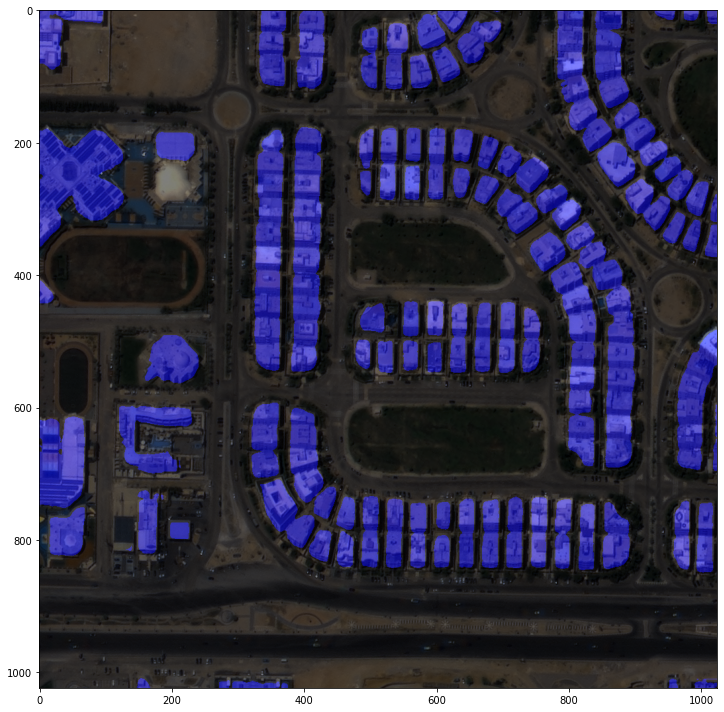

In [18]:
checkpoint_file = '/content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/LV2_building/batch1_dice_focal_lovasz_cutout_1000_0_1/iter_20000.pth'  #학습된 모델

# checkpoint 저장된 model 파일을 이용하여 모델을 생성, 이때 Config는 위에서 update된 config 사용. 
model_ckpt = init_segmentor(cfg, checkpoint_file, device='cuda:0')  #cuda gpu 사용

img = mmcv.imread('/content/drive/MyDrive/SIA/Data_set/building_dataset/img_dir/val/BLD00051_PS3_K3A_NIA0276.png')
result = inference_segmentor(model_ckpt, img)
show_result_pyplot(model_ckpt, img, result, palette)

load checkpoint from local path: /content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/LV2_building/batch1_dice_focal_lovasz_cutout_1000_0_1/iter_20000.pth


/content/mmsegmentation/mmseg/models/segmentors/base.py:289: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


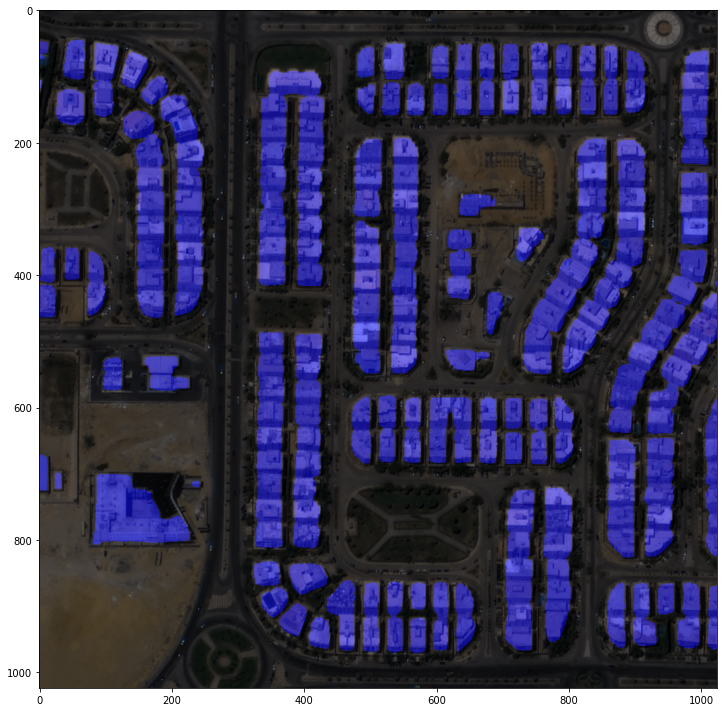

In [19]:
checkpoint_file = '/content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/LV2_building/batch1_dice_focal_lovasz_cutout_1000_0_1/iter_20000.pth'  #학습된 모델

# checkpoint 저장된 model 파일을 이용하여 모델을 생성, 이때 Config는 위에서 update된 config 사용. 
model_ckpt = init_segmentor(cfg, checkpoint_file, device='cuda:0')  #cuda gpu 사용

img = mmcv.imread('/content/drive/MyDrive/SIA/Data_set/building_dataset/img_dir/val/BLD00126_PS3_K3A_NIA0276.png')
result = inference_segmentor(model_ckpt, img)
show_result_pyplot(model_ckpt, img, result, palette)

load checkpoint from local path: /content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/LV2_building/batch1_dice_focal_lovasz_cutout_1000_0_1/iter_20000.pth


/content/mmsegmentation/mmseg/models/segmentors/base.py:289: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


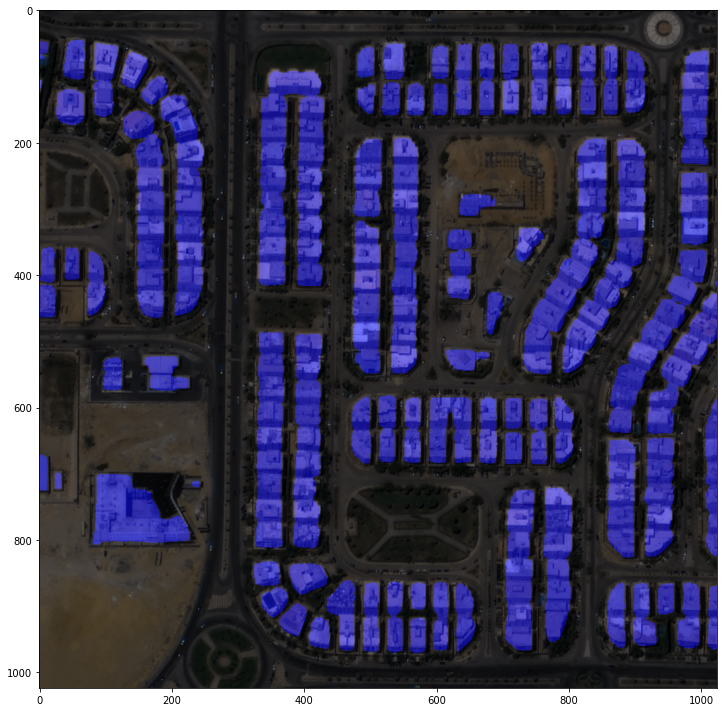

In [20]:
checkpoint_file = '/content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/LV2_building/batch1_dice_focal_lovasz_cutout_1000_0_1/iter_20000.pth'  #학습된 모델

# checkpoint 저장된 model 파일을 이용하여 모델을 생성, 이때 Config는 위에서 update된 config 사용. 
model_ckpt = init_segmentor(cfg, checkpoint_file, device='cuda:0')  #cuda gpu 사용

img = mmcv.imread('/content/drive/MyDrive/SIA/Data_set/building_dataset/img_dir/val/BLD00126_PS3_K3A_NIA0276.png')
result = inference_segmentor(model_ckpt, img)
show_result_pyplot(model_ckpt, img, result, palette)

load checkpoint from local path: /content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/LV2_building/batch1_dice_focal_lovasz_cutout_1000_0_1/iter_20000.pth


/content/mmsegmentation/mmseg/models/segmentors/base.py:289: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


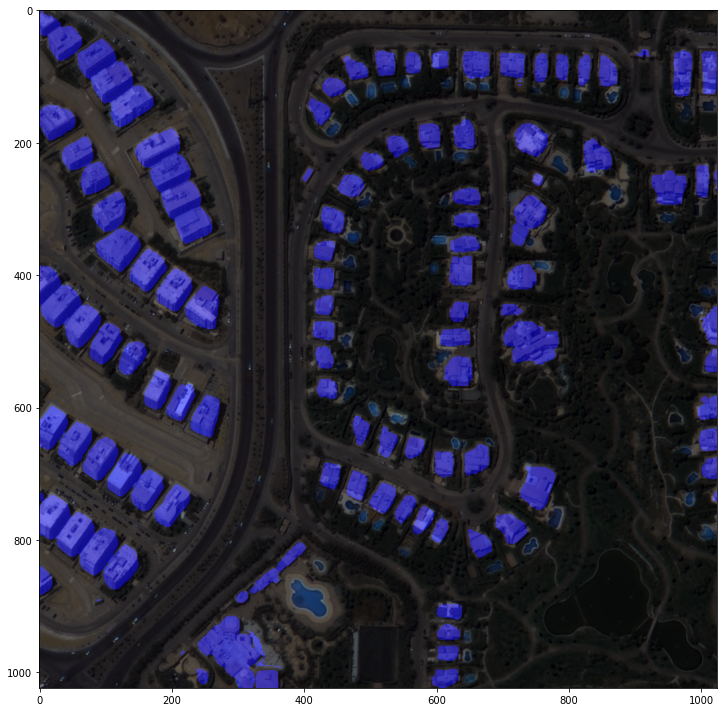

In [21]:
checkpoint_file = '/content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/LV2_building/batch1_dice_focal_lovasz_cutout_1000_0_1/iter_20000.pth'  #학습된 모델

# checkpoint 저장된 model 파일을 이용하여 모델을 생성, 이때 Config는 위에서 update된 config 사용. 
model_ckpt = init_segmentor(cfg, checkpoint_file, device='cuda:0')  #cuda gpu 사용

img = mmcv.imread('/content/drive/MyDrive/SIA/Data_set/building_dataset/img_dir/val/BLD00226_PS3_K3A_NIA0276.png')
result = inference_segmentor(model_ckpt, img)
show_result_pyplot(model_ckpt, img, result, palette)

load checkpoint from local path: /content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/LV2_building/batch1_dice_focal_lovasz_cutout_1000_0_1/iter_20000.pth


/content/mmsegmentation/mmseg/models/segmentors/base.py:289: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


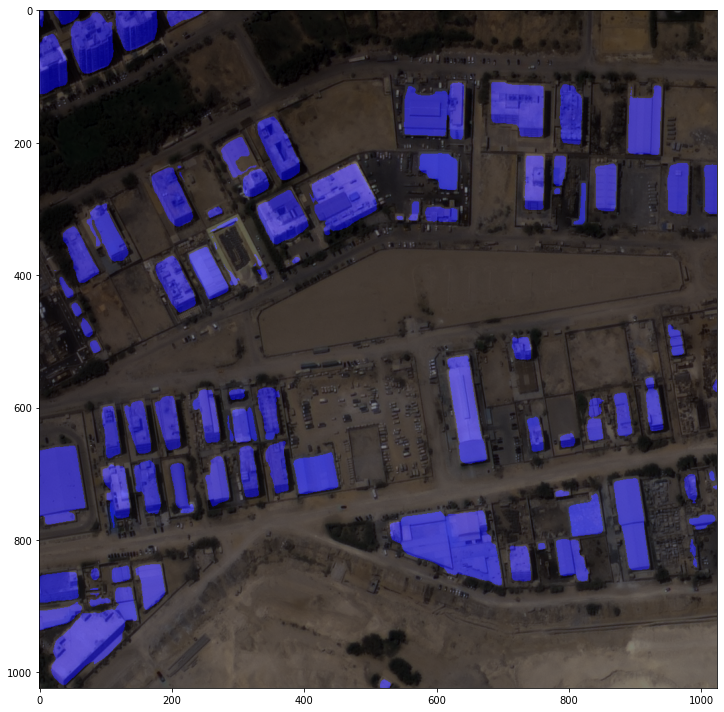

In [22]:
checkpoint_file = '/content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/LV2_building/batch1_dice_focal_lovasz_cutout_1000_0_1/iter_20000.pth'  #학습된 모델

# checkpoint 저장된 model 파일을 이용하여 모델을 생성, 이때 Config는 위에서 update된 config 사용. 
model_ckpt = init_segmentor(cfg, checkpoint_file, device='cuda:0')  #cuda gpu 사용

img = mmcv.imread('/content/drive/MyDrive/SIA/Data_set/building_dataset/img_dir/val/BLD00333_PS3_K3A_NIA0276.png')
result = inference_segmentor(model_ckpt, img)
show_result_pyplot(model_ckpt, img, result, palette)

#### 네이버 지도 이미지로 테스트

load checkpoint from local path: /content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/LV2_building/batch1_dice_focal_lovasz_cutout_1000_0_1/iter_20000.pth


/content/mmsegmentation/mmseg/models/segmentors/base.py:289: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


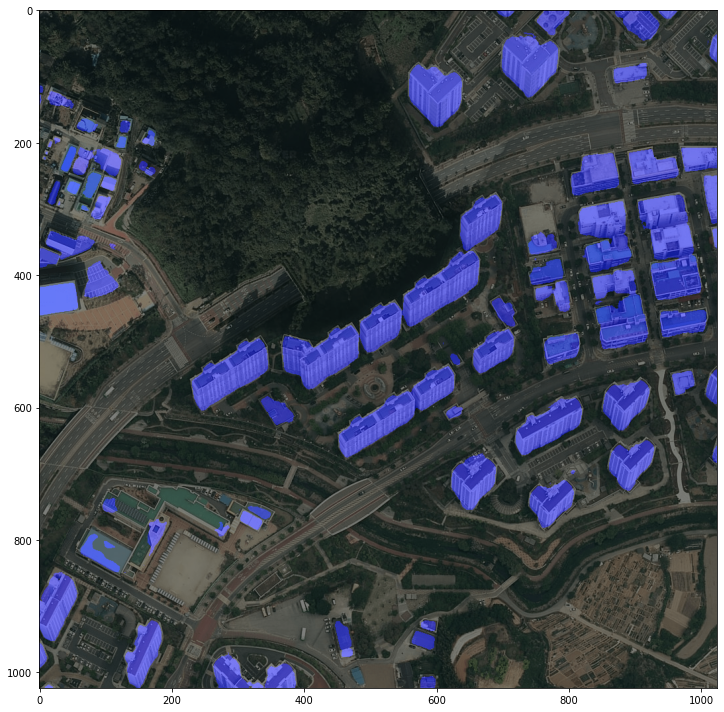

In [23]:
checkpoint_file = '/content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/LV2_building/batch1_dice_focal_lovasz_cutout_1000_0_1/iter_20000.pth'  #학습된 모델

# checkpoint 저장된 model 파일을 이용하여 모델을 생성, 이때 Config는 위에서 update된 config 사용. 
model_ckpt = init_segmentor(cfg, checkpoint_file, device='cuda:0')  #cuda gpu 사용

img = mmcv.imread('/content/drive/MyDrive/SIA/naver_map_images/0000.png')
result = inference_segmentor(model_ckpt, img)
show_result_pyplot(model_ckpt, img, result, palette)

load checkpoint from local path: /content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/LV2_building/batch1_dice_focal_lovasz_cutout_1000_0_1/iter_20000.pth


/content/mmsegmentation/mmseg/models/segmentors/base.py:289: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


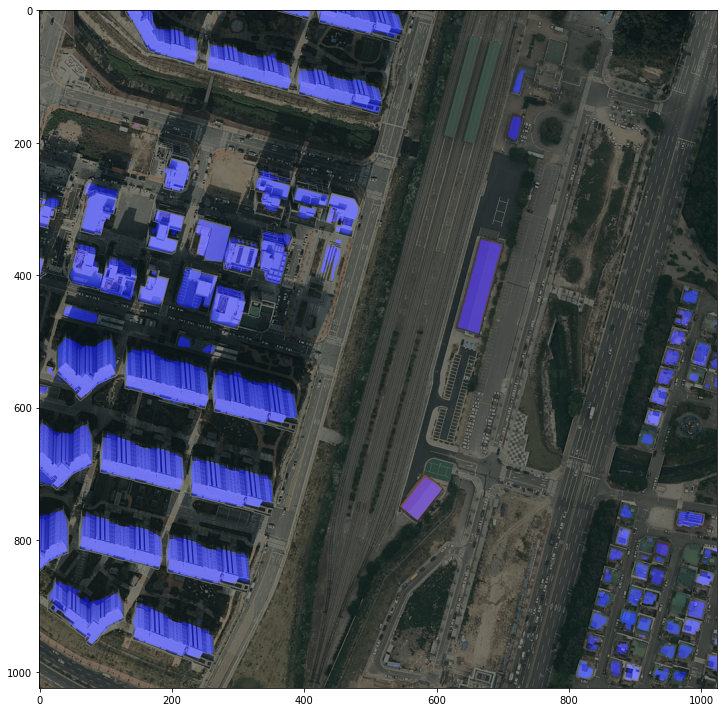

In [24]:
checkpoint_file = '/content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/LV2_building/batch1_dice_focal_lovasz_cutout_1000_0_1/iter_20000.pth'  #학습된 모델

# checkpoint 저장된 model 파일을 이용하여 모델을 생성, 이때 Config는 위에서 update된 config 사용. 
model_ckpt = init_segmentor(cfg, checkpoint_file, device='cuda:0')  #cuda gpu 사용

img = mmcv.imread('/content/drive/MyDrive/SIA/naver_map_images/0001.png')
result = inference_segmentor(model_ckpt, img)
show_result_pyplot(model_ckpt, img, result, palette)

load checkpoint from local path: /content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/LV2_building/batch1_dice_focal_lovasz_cutout_1000_0_1/iter_20000.pth


/content/mmsegmentation/mmseg/models/segmentors/base.py:289: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


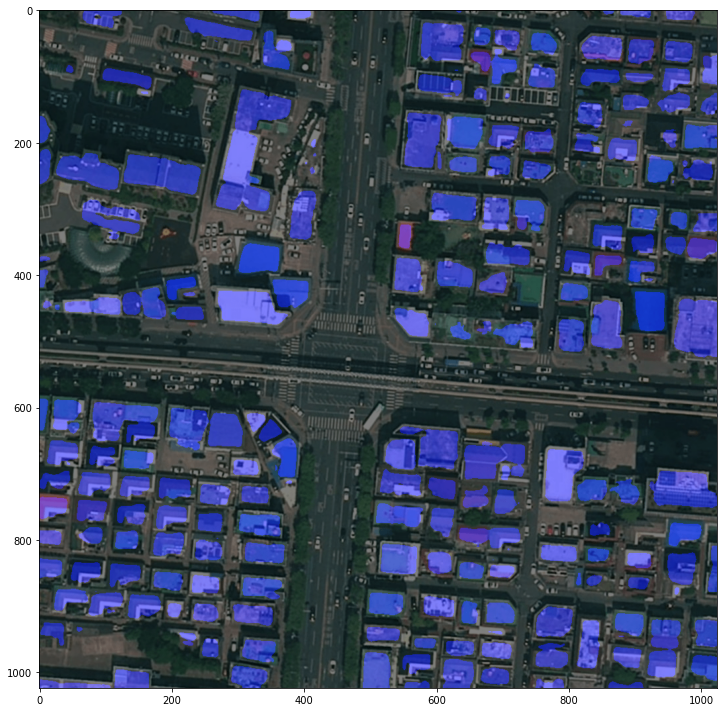

In [25]:
checkpoint_file = '/content/drive/MyDrive/SIA/semantic_checkpoint/Segformer/LV2_building/batch1_dice_focal_lovasz_cutout_1000_0_1/iter_20000.pth'  #학습된 모델

# checkpoint 저장된 model 파일을 이용하여 모델을 생성, 이때 Config는 위에서 update된 config 사용. 
model_ckpt = init_segmentor(cfg, checkpoint_file, device='cuda:0')  #cuda gpu 사용

img = mmcv.imread('/content/drive/MyDrive/SIA/naver_map_images/0002.png')
result = inference_segmentor(model_ckpt, img)
show_result_pyplot(model_ckpt, img, result, palette)